# PHYS330, Ocean Lab 3, Working with large datasets - calculationg ENSO 

This notebook introduces working with large climate datasets. 

Logging into see-trx4001
Step 1: open a user account using powershell on windows or linux/mac terminal
Step 2: secure shell into see-trx4001 linux computer ssh usr123@see-trx4001.canterbury.ac.nz then hit enter
Step 3: use your internet browser to log into the JupyterLab server https://see-trx4001.canterbury.ac.nz:9552/


ENSO can be defined using several parameters:

* Sea Lelvel Pressure diffrerence (SOI) The negative phase of the SOI represents below-normal air pressure at Tahiti and above-normal air pressure at Darwin. 
https://www.ncei.noaa.gov/access/monitoring/enso/soi

* See Surface temperature anomaly
El Niño (La Niña) is a phenomenon in the equatorial Pacific Ocean characterized by a five consecutive 3-month running mean of sea surface temperature (SST) anomalies in the Niño 3.4 region that is above (below) the threshold of +0.5°C (-0.5°C). This standard of measure is known as the Oceanic Niño Index (ONI).

* SST Principal Component Analysis 
    https://kls2177.github.io/Climate-and-Geophysical-Data-Analysis/chapters/Week7/Intro_to_PCA.html
    


In [ ]:
https://github.com/royalosyin/Python-Practical-Application-on-Climate-Variability-Studies/blob/master/ex34-Correlations%20between%20SOI%20and%20SLP%2C%20Temperature%20and%20Precipitation.ipynbhttps://github.com/royalosyin/Python-Practical-Application-on-Climate-Variability-Studies/blob/master/ex34-Correlations%20between%20SOI%20and%20SLP%2C%20Temperature%20and%20Precipitation.ipynb

https://github.com/royalosyin/Python-Practical-Application-on-Climate-Variability-Studies/tree/master

https://fabienmaussion.info/climate_system/projects/02_GuidedExercise_Composites.html


https://climatemathematics.sdsu.edu/images/PythonClimMathCh4.html

https://jonathonwright.github.io/olwork.html


### Section 1.  Calculate ONI index (mean anomaly over 3.4 box)

SST dataset: ERSST version 5
https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html

Monthly values, 1854 - present


How the dataset has been dowloaded:

`mkdir ERSST`

`cd ERSST`

`wget -r -nd -R "index.html*" https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/netcdf/ .`

 The dataset comes in yearly files, but has been merged into one file for your convinience

`cdo mergetime ersst.*.nc ersst_all.nc`


#### Section 1.1 - plot the values from the file, define the ONI region

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
from scipy.signal import detrend
import pandas as pd
import warnings

#library to handle time variable in the SST file
import cftime as cftime
warnings.filterwarnings('ignore')

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/envs/baseline/share/proj failed


In [2]:
#Load the dataset
sst = xr.open_dataset("ERSST_full_record.nc")

#as this is a single level dataset, we can remove that dimention
sst = xr.open_dataset("ERSST_full_record.nc").squeeze("lev").drop("lev")

<b>Task 1: Inverstigate 2 variables in the dataset</b>

<b>What are their names:</b>

<b>Time period:</b>

<b>Horizontal resolution:</b>

In [3]:
sst

<xarray.Dataset>
Dimensions:  (time: 2048, lon: 180, lat: 89)
Coordinates:
  * time     (time) object 1854-01-01 00:00:00 ... 2024-08-15 00:00:00
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
Data variables:
    sst      (time, lat, lon) float32 ...
    ssta     (time, lat, lon) float32 ...
Attributes: (12/40)
    CDI:                        Climate Data Interface version 2.0.4 (https:/...
    Conventions:                CF-1.6, ACDD-1.3
    source:                     In situ data: ICOADS R3.0 before 2015, NCEP i...
    institution:                NOAA/NESDIS/NCEI/CCOG
    metadata_link:              https://doi.org/10.7289/V5T72FNM
    id:                         ersst.v5.185401
    ...                         ...
    platform:                   Ship and Buoy SSTs from ICOADS R3.0 and NCEP GTS
    instrument:                 Conventional thermometers
    comment:                    SSTs were observed by conventional thermomete...
    references:                 Huang et al, 2017: Extended Reconstructed Sea...
    climatology:                Climatology is based on 1971-2000 SST, Xue, Y...
    CDO:                        Climate Data Operators version 2.0.4 (https:/...

In [4]:
# define Nino3.4 region boundaries
lon1 = 360-170; lon2 = 360-120
lat1 = -5; lat2 = 5
# also the other NINO regions
# Nino1.2
lon1_12 = 360-90; lon2_12 = 360-80
lat1_12 = -10; lat2_12 = 0
# Nino3
lon1_3 = 360-150; lon2_3 = 360-90
lat1_3 = -5; lat2_3 = 5
# Nino4
lon1_4 = 160; lon2_4 = 360-150
lat1_4 = -5; lat2_4 = 5

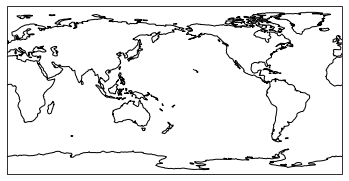

In [5]:
# define projection of SST data: lonlat grid -> "PlateCarree()"
data_proj = ccrs.PlateCarree()
# define projection for maps
proj = ccrs.PlateCarree(central_longitude=180)

# create figure and axis with map projection
fig, ax = plt.subplots(1,1,subplot_kw={'projection':proj})
# draw some coastlines
ax.coastlines();

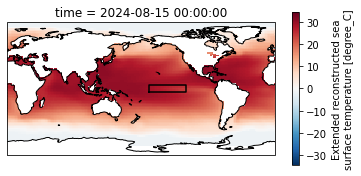

In [6]:
# create figure and axis with map projection
fig, ax = plt.subplots(1,1,subplot_kw={'projection':proj})
# draw some coastlines
ax.coastlines();


# plot SST for last month,
# i.e, the last time index, -1
sst["sst"][-1].plot(ax=ax,transform=data_proj,cbar_kwargs={"shrink": 0.7})
# plot extend of Nino3.4
nino34 = [lon1,lon2,lon2,lon1,lon1],[lat1,lat1,lat2,lat2,lat1]
ax.plot(*nino34,'k-',transform=data_proj)

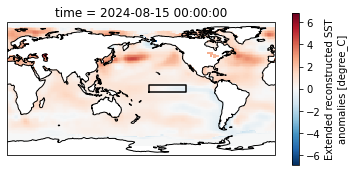

In [7]:
# create figure and axis with map projection
fig, ax = plt.subplots(1,1,subplot_kw={'projection':proj})
# draw some coastlines
ax.coastlines();


# plot SST anomalies for last month,
# i.e, the last time index, -1
sst["ssta"][-1].plot(ax=ax,transform=data_proj,cbar_kwargs={"shrink": 0.7})
# plot extend of Nino3.4
nino34 = [lon1,lon2,lon2,lon1,lon1],[lat1,lat1,lat2,lat2,lat1]
ax.plot(*nino34,'k-',transform=data_proj)

<b>Task 2: Add three other Nino regions to the map</b>

nino12 =

ax.plot(*nino12,'k--',lw=1,transform=data_proj)



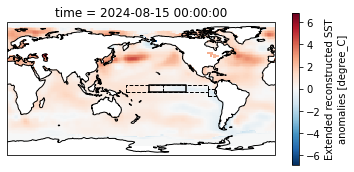

In [8]:
# create figure and axis with map projection
fig, ax = plt.subplots(1,1,subplot_kw={'projection':proj})
# draw some coastlines
ax.coastlines();

# plot SST anomalies for last month,
# i.e, the last time index, -1
sst["ssta"][-1].plot(ax=ax,transform=data_proj,cbar_kwargs={"shrink": 0.7})
# plot extend of Nino3.4
nino34 = [lon1,lon2,lon2,lon1,lon1],[lat1,lat1,lat2,lat2,lat1]
ax.plot(*nino34,'k-',transform=data_proj)



# add other Nino region outlines 
nino12 = [lon1_12,lon2_12,lon2_12,lon1_12,lon1_12],[lat1_12,lat1_12,lat2_12,lat2_12,lat1_12]
ax.plot(*nino12,'k--',lw=1,transform=data_proj)
nino3 = [lon1_3,lon2_3,lon2_3,lon1_3,lon1_3],[lat1_3,lat1_3,lat2_3,lat2_3,lat1_3]
ax.plot(*nino3,'k--',lw=1,transform=data_proj)
nino4 = [lon1_4,lon2_4,lon2_4,lon1_4,lon1_4],[lat1_4,lat1_4,lat2_4,lat2_4,lat1_4]
ax.plot(*nino4,'k--',lw=1,transform=data_proj);


#### Section 1.2 - Calculate ONI in Nino3.4

In [9]:
# slice dataset along Nino3.4 boundaries
# i.e., between "lon1" and "lon2",
# and between "lat1" and "lat2"

sst_a = sst["ssta"].loc[{
    'lat': slice(lat1,lat2),
    'lon': slice(lon1,lon2)
}]

# Mean over area, running mean over 3 months
sst_a_mean=sst_a.mean(dim=["lat","lon"])
sst_a_running=sst_a_mean.rolling(time=3, center=True).mean()

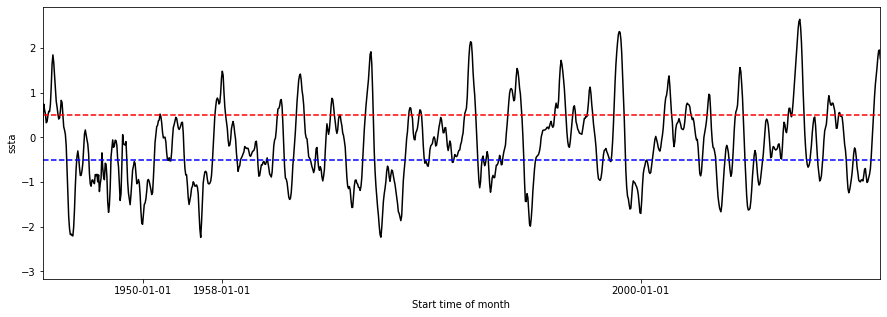

In [27]:
fig, ax = plt.subplots(figsize=(15,5))

timeticks=np.array([cftime.Datetime360Day(1900, 1, 1, 0, 0, 0, 0, has_year_zero=True),
                    cftime.Datetime360Day(1950, 1, 1, 0, 0, 0, 0, has_year_zero=True),
                    cftime.Datetime360Day(1958, 1, 1, 0, 0, 0, 0, has_year_zero=True),
                    cftime.Datetime360Day(2000, 1, 1, 0, 0, 0, 0, has_year_zero=True),],
                    dtype=object)

sst_a_running.plot.line(ax=ax, color='black',xticks=timeticks)

ax.set_xlim(cftime.Datetime360Day(1940, 1, 1, 0, 0, 0, 0, has_year_zero=True),cftime.Datetime360Day(2024, 1, 1, 0, 0, 0, 0, has_year_zero=True))

# Add lines to define ONI limits
ax.axhline(y=0.5, color='r', linestyle='--', label='Threshold')
ax.axhline(y=-0.5, color='b', linestyle='--', label='Threshold')

<b>Task 3: Which years are La Nina? El Nino ? Give 5 exmaples of each. </b>
    
Hint: Play with xlim and/or timeticks to find out dates
    


## Section 2: How does ENSO affect New Zealnd? 

https://niwa.co.nz/el-nino-and-la-nina

<b> Task 4: Read the page and aswer the questions: </b> 

1) Is there a uniform effect for the whole country?  

2) Is there a uniform effect for the whole year?

Next we look at ERA5 files for NZ and choose 2 locations: Auckland and Christchurch 

In [15]:
# define a function that subtracts the mean along the "time" dimension
def subtract(x):
    return x - x.mean(dim="time")

# define our custom detrend function that also fills NaNs with 0s
def detrend_(x):
    return detrend(x.fillna(0),axis=0)

In [11]:
lon_a=174.76
lat_a=-36.85

lon_c=172.64
lat_c=-43.53

era5=xr.open_dataset('era5_nz_all.nc')
era5


<xarray.Dataset>
Dimensions:    (time: 20682, longitude: 81, latitude: 81)
Coordinates:
  * time       (time) datetime64[ns] 1940-01-01 ... 1952-12-31T18:00:00
  * longitude  (longitude) float32 160.0 160.2 160.5 160.8 ... 179.5 179.8 180.0
  * latitude   (latitude) float32 -30.0 -30.25 -30.5 ... -49.5 -49.75 -50.0
Data variables:
    t2m        (time, latitude, longitude) float64 ...
    tp         (time, latitude, longitude) float64 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Sep 12 14:33:49 2024: cdo -b F64 -f nc2 mergetime era5_...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

In [12]:
temp_a=era5.t2m.sel(longitude=lon_a,latitude=lat_a,method="nearest")

(-10958.0, 19723.0)

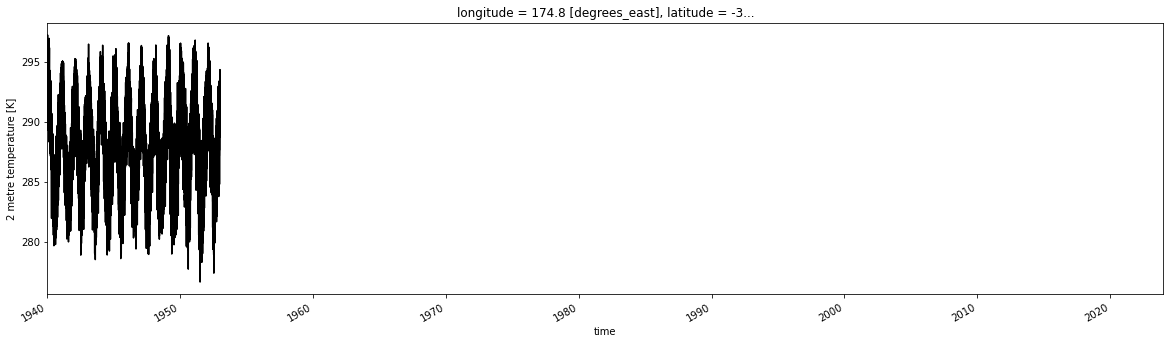

In [28]:
fig, ax = plt.subplots(figsize=(20,5))
temp_a.plot.line(ax=ax, color='black')
ax.set_xlim(pd.to_datetime(['1940-01-01', '2024-01-01']))

In [16]:
#Calculate temperature Anomaly (detrend+ remove mean value, remove seasonal signal)
# Save original variable:
temp0=era5

# apply the detrending, save variable after
era5 = era5.map(detrend_)
temp1=era5

# apply the subtraction of the monthly means, using "groupby", save the final variable
era5 = era5.groupby("time.month").map(subtract)
temp2=era5




(-10958.0, 19723.0)

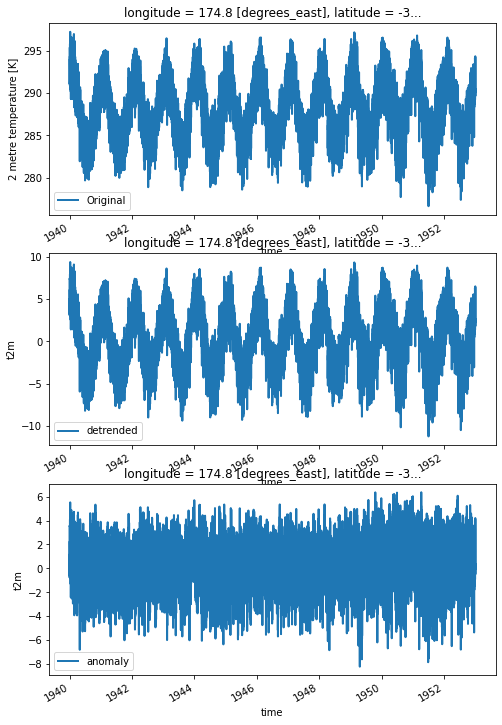

In [29]:
#Plot all three records to undertand what happened:
fig, axes = plt.subplots(3, 1, figsize=(8, 12))


temp0["t2m"].sel(longitude=lon_a,latitude=lat_a,method='nearest').plot(label="Original",lw=2,ax=axes[0])
axes[0].legend()

temp1["t2m"].sel(longitude=lon_a,latitude=lat_a,method='nearest').plot(label="detrended",lw=2,ax=axes[1])
axes[1].legend()

temp2["t2m"].sel(longitude=lon_a,latitude=lat_a,method='nearest').plot(label="anomaly",lw=2,ax=axes[2])
axes[2].legend()
ax.set_xlim(pd.to_datetime(['1940-01-01', '2024-01-01']))

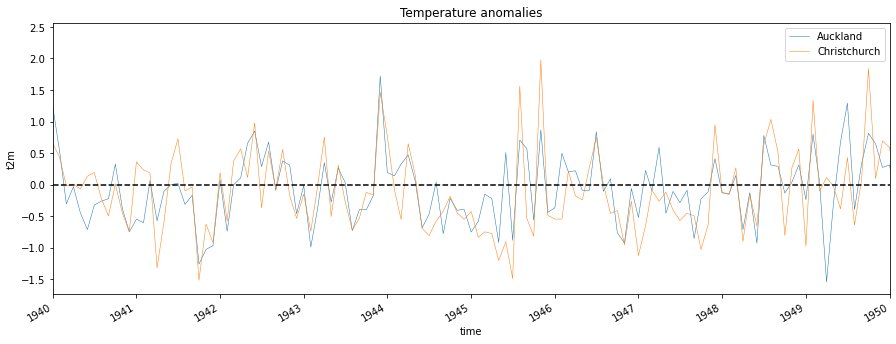

In [18]:
# plot the climatological monthly means of anomalies as time series for a location 
fig, ax = plt.subplots(figsize=(15,5))
era5["t2m"].resample(time="1MS").mean() \
            .sel(longitude=lon_a,latitude=lat_a,method='nearest').plot(label="Auckland",lw=0.5,ax=ax)
era5["t2m"].resample(time="1MS").mean() \
            .sel(longitude=lon_c,latitude=lat_c,method='nearest').plot(label="Christchurch",lw=0.5,ax=ax)

ax.set_xlim(pd.to_datetime(['1940-01-01', '1950-01-01']))
plt.legend();
plt.title('Temperature anomalies');
ax.axhline(y=0, color='k', linestyle='--', label='Threshold')

<b> Task 7: Repeat the plot with precipitaion records </b>

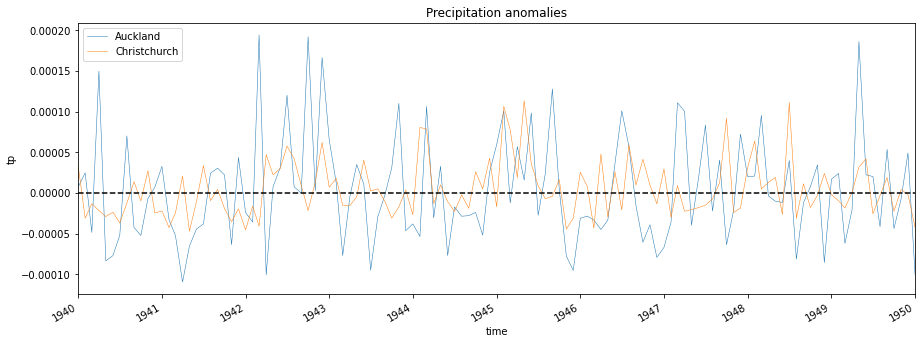

In [21]:
fig, ax = plt.subplots(figsize=(15,5))
era5["tp"].resample(time="1MS").mean() \
            .sel(longitude=lon_a,latitude=lat_a,method='nearest').plot(label="Auckland",lw=0.5,ax=ax)
era5["tp"].resample(time="1MS").mean() \
            .sel(longitude=lon_c,latitude=lat_c,method='nearest').plot(label="Christchurch",lw=0.5,ax=ax)

ax.set_xlim(pd.to_datetime(['1940-01-01', '1950-01-01']))
plt.legend();
plt.title('Precipitation anomalies');
ax.axhline(y=0, color='k', linestyle='--', label='Threshold')

<b> Task 8: Plot ONI for the same time period </b>

#hint on time limit with ERSST time varibale format:

ax.set_xlim(cftime.Datetime360Day(1940, 1, 1, 0, 0, 0, 0, has_year_zero=True),cftime.Datetime360Day(1950, 1, 1, 0, 0, 0, 0, has_year_zero=True))


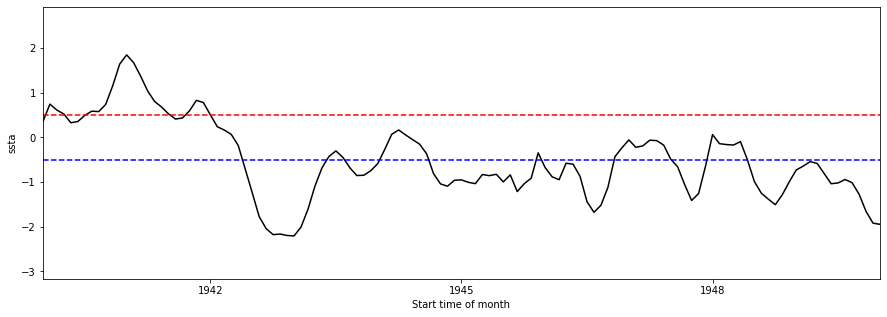

In [22]:
fig, ax = plt.subplots(figsize=(15,5))
sst_a_running.plot.line(ax=ax,color='black')
ax.set_xlim(cftime.Datetime360Day(1940, 1, 1, 0, 0, 0, 0, has_year_zero=True),cftime.Datetime360Day(1950, 1, 1, 0, 0, 0, 0, has_year_zero=True))
ax.axhline(y=0.5, color='r', linestyle='--', label='Threshold')
ax.axhline(y=-0.5, color='b', linestyle='--', label='Threshold')

<b> Task 9: Describe the relationship between ONI, temperature and precipitaion records. Hint: focus on the two years with the strongest ONI signal.
    Use NIWA's page for guidance if needed. </b>


<b> Task 10: Plot a scatter plot of temperature and ONI relationship. To do so, convert era5 to monthly means again! </b>

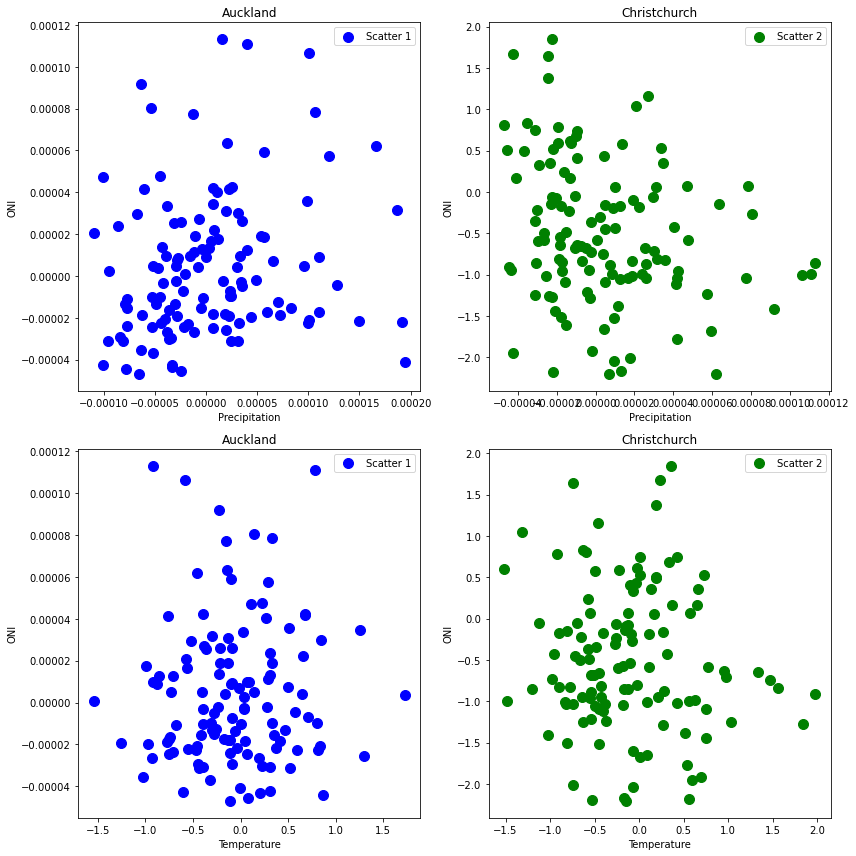

In [25]:
a=era5["tp"].resample(time="1MS").mean().sel(longitude=lon_a,latitude=lat_a,method='nearest').sel(time=slice("1940-01-01","1950-01-01"))
c=era5["tp"].resample(time="1MS").mean().sel(longitude=lon_c,latitude=lat_c,method='nearest').sel(time=slice("1940-01-01","1950-01-01"))

a_temp=era5["t2m"].resample(time="1MS").mean().sel(longitude=lon_a,latitude=lat_a,method='nearest').sel(time=slice("1940-01-01","1950-01-01"))
c_temp=era5["t2m"].resample(time="1MS").mean().sel(longitude=lon_c,latitude=lat_c,method='nearest').sel(time=slice("1940-01-01","1950-01-01"))

b=sst_a_running.sel(time=slice("1940-01-01","1950-01-01"))
np.shape(a), np.shape(b)



# Create a figure with 2 subplots (1 row, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# First subplot (scatter plot 1)
axes[0,0].scatter(a, c, color='blue', label="Scatter 1", s=100)
axes[0,0].set_title('Auckland')
axes[0,0].set_xlabel('Precipitation')
axes[0,0].set_ylabel('ONI')
axes[0,0].legend()

# Second subplot (scatter plot 2)
axes[0,1].scatter(c, b, color='green', label="Scatter 2", s=100)
axes[0,1].set_title('Christchurch')
axes[0,1].set_xlabel('Precipitation')
axes[0,1].set_ylabel('ONI')
axes[0,1].legend()

# First subplot (scatter plot 1)
axes[1,0].scatter(a_temp, c, color='blue', label="Scatter 1", s=100)
axes[1,0].set_title('Auckland')
axes[1,0].set_xlabel('Temperature')
axes[1,0].set_ylabel('ONI')
axes[1,0].legend()

# Second subplot (scatter plot 2)
axes[1,1].scatter(c_temp, b, color='green', label="Scatter 2", s=100)
axes[1,1].set_title('Christchurch')
axes[1,1].set_xlabel('Temperature')
axes[1,1].set_ylabel('ONI')
axes[1,1].legend()


# Adjust the layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

<b> Task 11: Repeat task 10 for 1940-2023  and discuss the change in results</b>

ValueError: x and y must be the same size

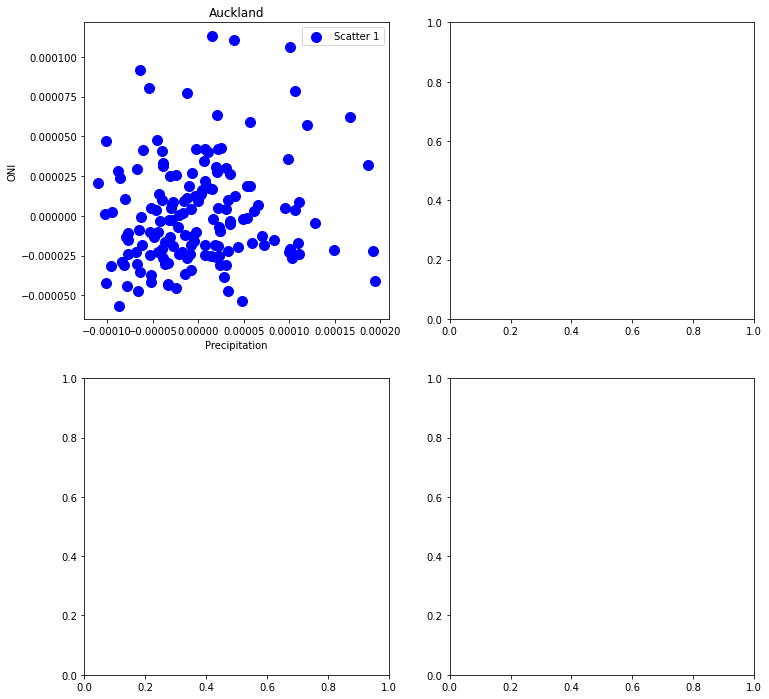

In [30]:
a=era5["tp"].resample(time="1MS").mean().sel(longitude=lon_a,latitude=lat_a,method='nearest').sel(time=slice("1940-01-01","2024-01-01"))
c=era5["tp"].resample(time="1MS").mean().sel(longitude=lon_c,latitude=lat_c,method='nearest').sel(time=slice("1940-01-01","2024-01-01"))

a_temp=era5["t2m"].resample(time="1MS").mean().sel(longitude=lon_a,latitude=lat_a,method='nearest').sel(time=slice("1940-01-01","2024-01-01"))
c_temp=era5["t2m"].resample(time="1MS").mean().sel(longitude=lon_c,latitude=lat_c,method='nearest').sel(time=slice("1940-01-01","2024-01-01"))

b=sst_a_running.sel(time=slice("1940-01-01","2024-01-01"))
np.shape(a), np.shape(b)



# Create a figure with 2 subplots (1 row, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# First subplot (scatter plot 1)
axes[0,0].scatter(a, c, color='blue', label="Scatter 1", s=100)
axes[0,0].set_title('Auckland')
axes[0,0].set_xlabel('Precipitation')
axes[0,0].set_ylabel('ONI')
axes[0,0].legend()

# Second subplot (scatter plot 2)
axes[0,1].scatter(c, b, color='green', label="Scatter 2", s=100)
axes[0,1].set_title('Christchurch')
axes[0,1].set_xlabel('Precipitation')
axes[0,1].set_ylabel('ONI')
axes[0,1].legend()

# First subplot (scatter plot 1)
axes[1,0].scatter(a_temp, c, color='blue', label="Scatter 1", s=100)
axes[1,0].set_title('Auckland')
axes[1,0].set_xlabel('Temperature')
axes[1,0].set_ylabel('ONI')
axes[1,0].legend()

# Second subplot (scatter plot 2)
axes[1,1].scatter(c_temp, b, color='green', label="Scatter 2", s=100)
axes[1,1].set_title('Christchurch')
axes[1,1].set_xlabel('Temperature')
axes[1,1].set_ylabel('ONI')
axes[1,1].legend()


# Adjust the layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()